In [1]:
import os
import json
import shutil
from datetime import datetime
import gym
import numpy as np
import pandas as pd
import torch
import yaml

from dateutil.relativedelta import relativedelta
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor

from src.data.dataloader import load_solar_profile
from src.utilities import *
from src.visualization.visualize import visualize_transitions
from src.pipelines.solar_fuel_op_usingstablebl import rl_model_testing
from src.global_variables import MAX_SOLAR_IN,\
                                 MIN_SOLAR_IN,\
                                 MAX_BATTERY_STORAGE_CAPACITY,\
                                 MIN_BATTERY_STORAGE_CAPACITY
from scipy.integrate import simpson
import matplotlib as mpl   
import matplotlib.pyplot as plt   
from bokeh.io import output_notebook
GLOBALCOUNTER=1
mpl.rcParams['figure.dpi'] = 300
%matplotlib inline

/glb/hou/gf.siti/data/rl_sfo/anaconda3/envs/rl-solar/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Random seed is : 34


In [2]:
battery_storage_capacity = 5000
curtail_unit_cost = 1
electrolyzer_cost = 1e-6
eval_freq = 500
h2_demand = 64400
h2_price = 5
hyperparameters_optimization = False
initial_month_test = "Jan"
initial_month_train = "Jan"
num_of_months_test = 1
num_of_months_train = 1
penalty_unit_cost = 5
steps_scale_factor = 2000
quantity_of_months_test = 1 
year=2015

experiment_name = f'June13_Test_Soft_Boundaries_Train_{initial_month_test}_Test_{initial_month_test}_094602'

data_path = '/glb/hou/gf.siti/data/rl_sfo/luiz_code/'\
                'solar_fuel_ReinforcementLearning/data/'\
                'solar_profile_hourlyV2.csv'
path = '/glb/hou/gf.siti/data/rl_sfo/luiz_code'
results_path = f'{path}/results/{experiment_name}'
log_path= f'{results_path}/callbacks'

baseline_path = f'{path}/solar_fuel_ReinforcementLearning/data/baseline_trained_Jan_TMY P90.csv'

In [3]:
whole_year_supply_df = load_solar_profile(data_path=data_path, year="TMY P90", initial_month=initial_month_test, number_of_months=num_of_months_test)
len_t_test=len(whole_year_supply_df)

model_path = '/glb/hou/gf.siti/data/rl_sfo/luiz_code/results/August09_Real_Runs_Solar_profil_Demand_lower_LR_Jul_140000/best_model/best_model.zip'
model = PPO.load(model_path)

houry_demand_train = calculate_hourly_demand(whole_year_supply=whole_year_supply_df,
                                             total_demand=h2_demand,
                                             buffer_demand=4500)

Whole Year Supply DF description
             hour        volume
count  744.000000    744.000000
mean   372.500000   2342.088198
std    214.918589   3237.723397
min      1.000000      0.000000
25%    186.750000      0.000000
50%    372.500000      0.000000
75%    558.250000   5513.913680
max    744.000000  10303.159520
The sum of the whole energy volume is 37752422.82975999
Total duration 744
Number of hours without sun: 15
Total Demand: 64400
Buffer Demand: 5000
Hourly Buffer Demand: 429.3333333333333
Remain Demand: 57960.0
Total demand per day integrating the profile: 1931160.0


### Result with first 100 points

Return is -1.0093283922998262
Return is -7.332928387720545


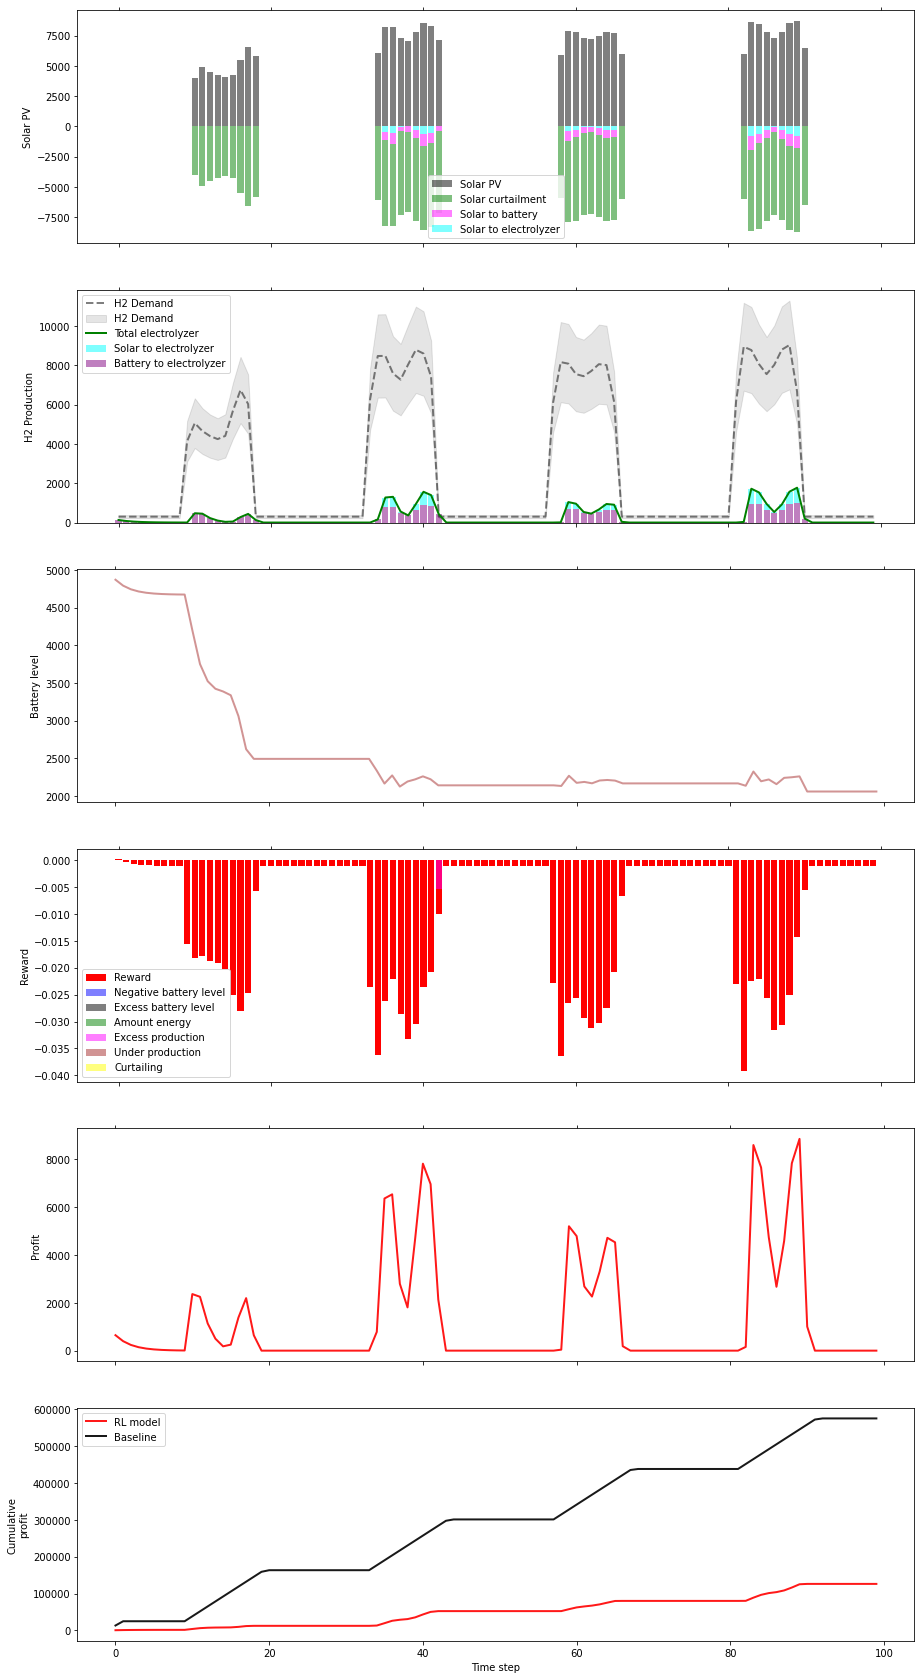

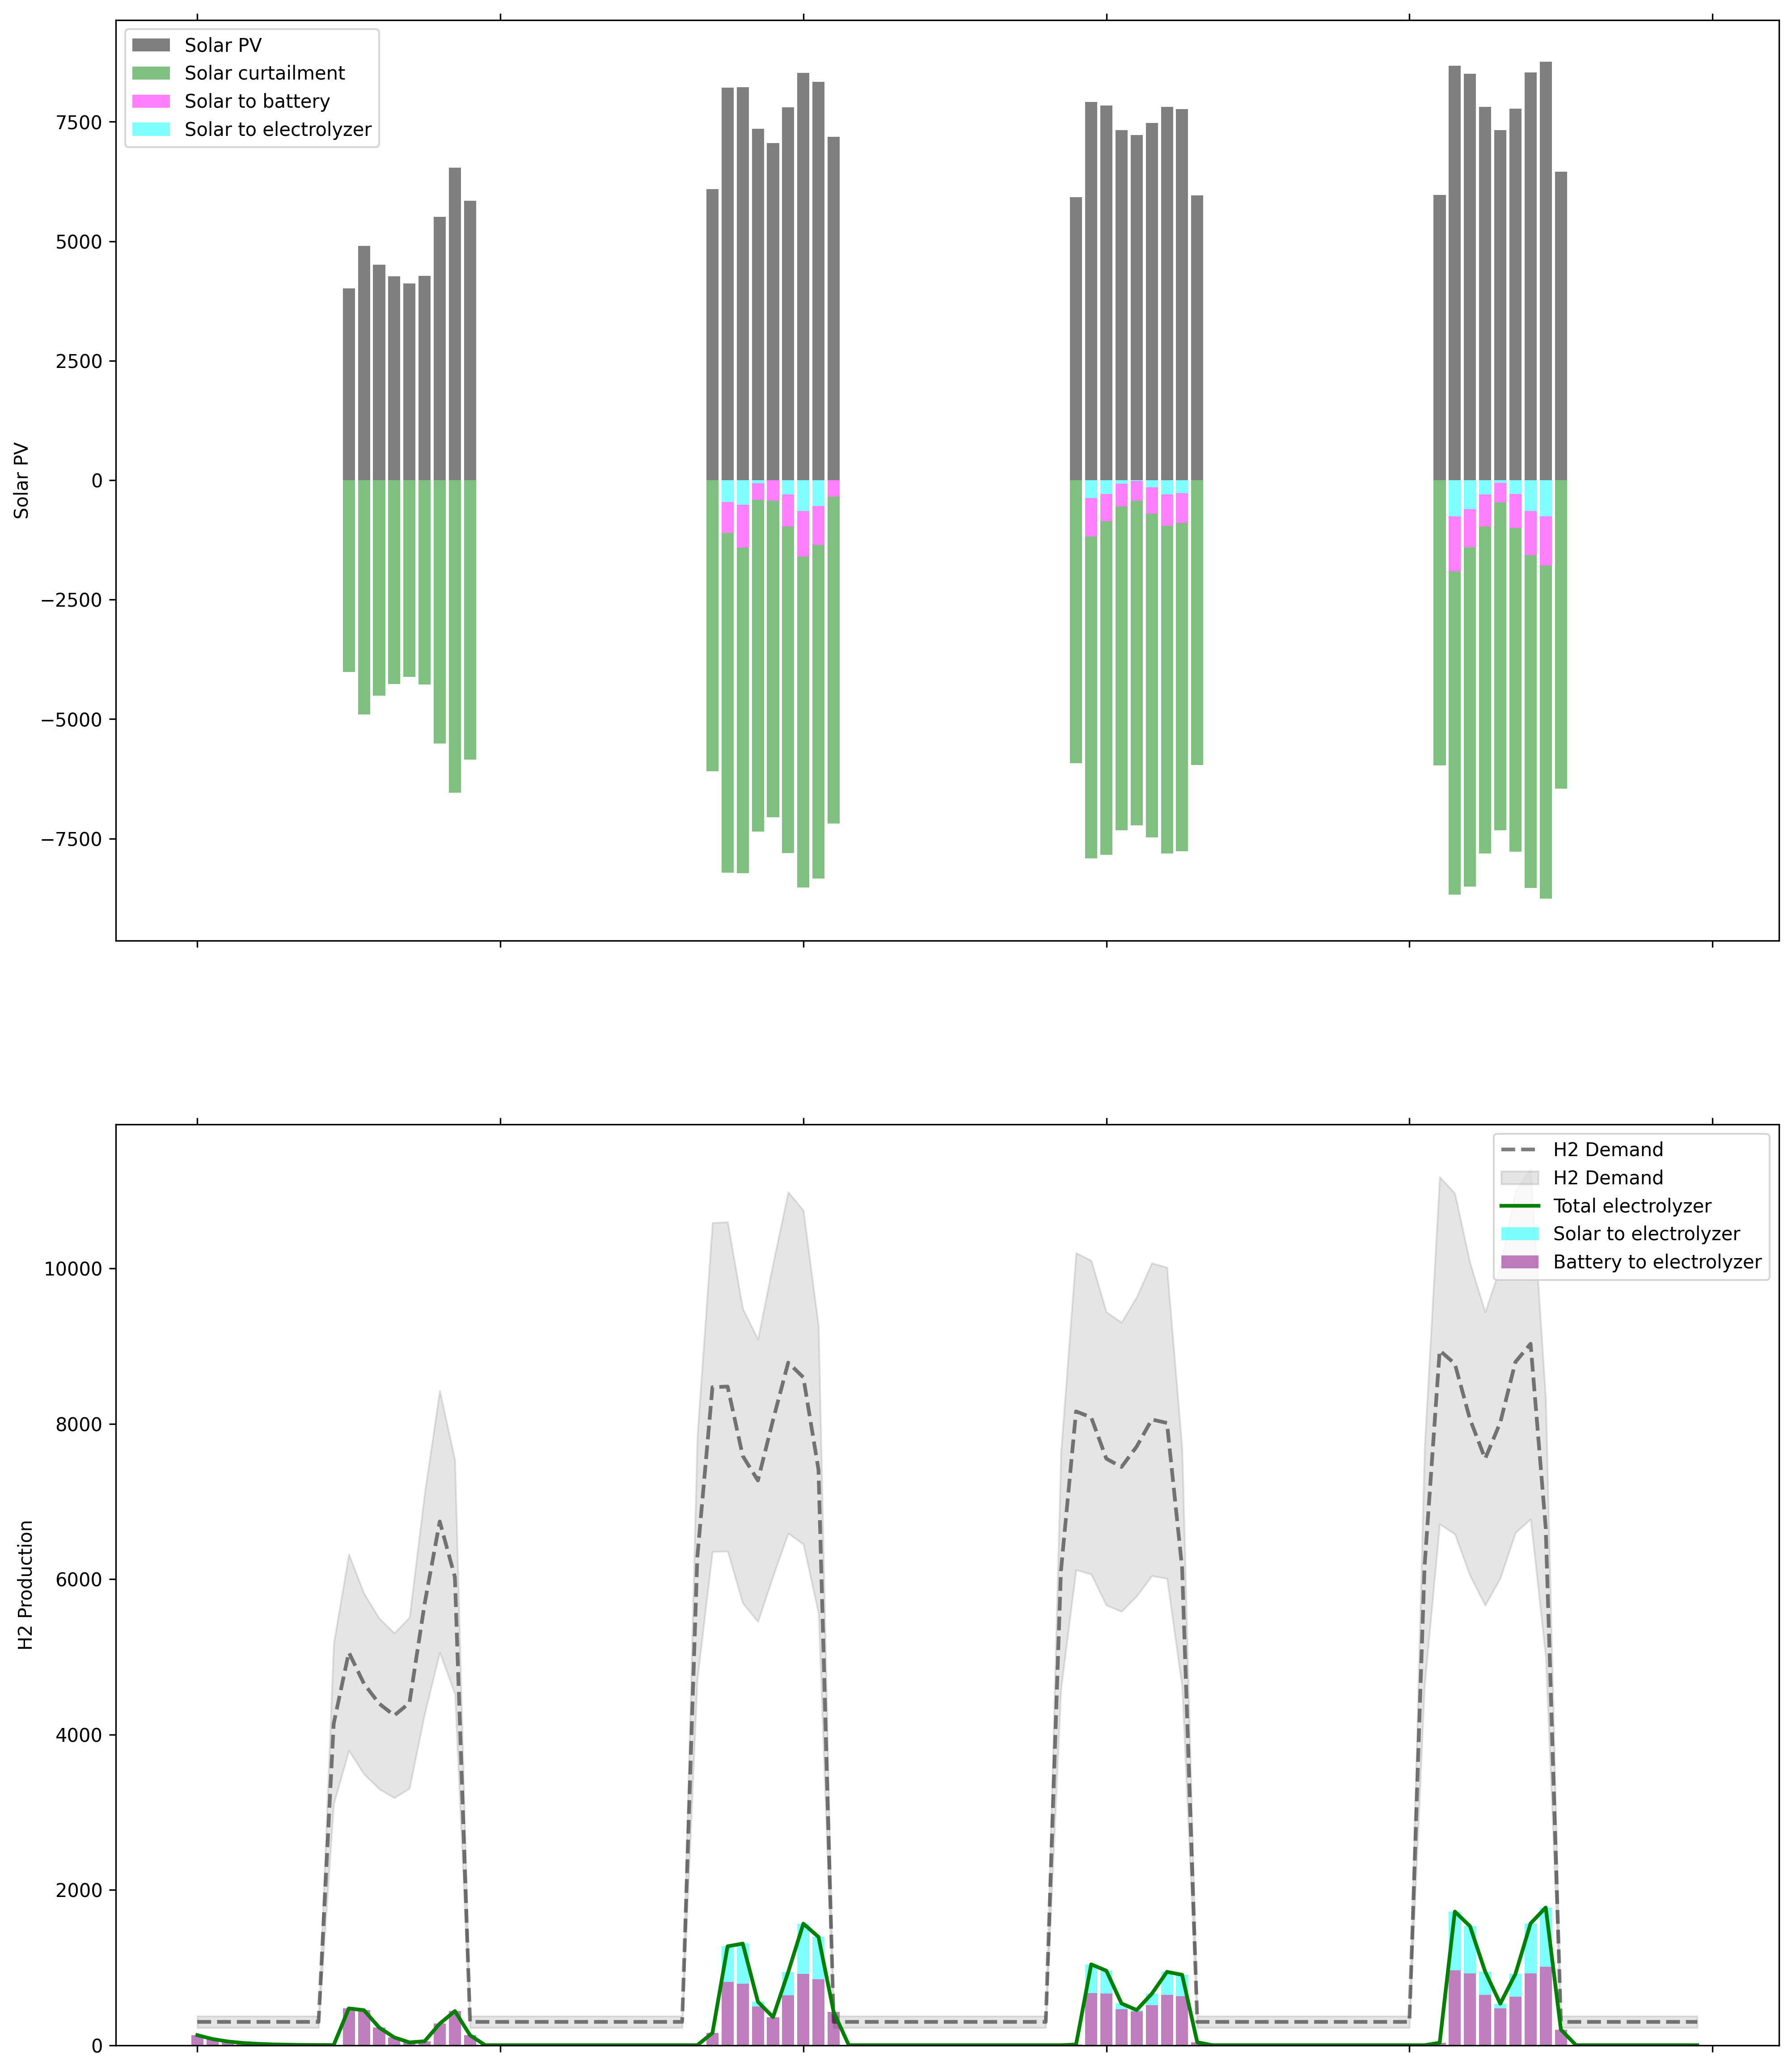

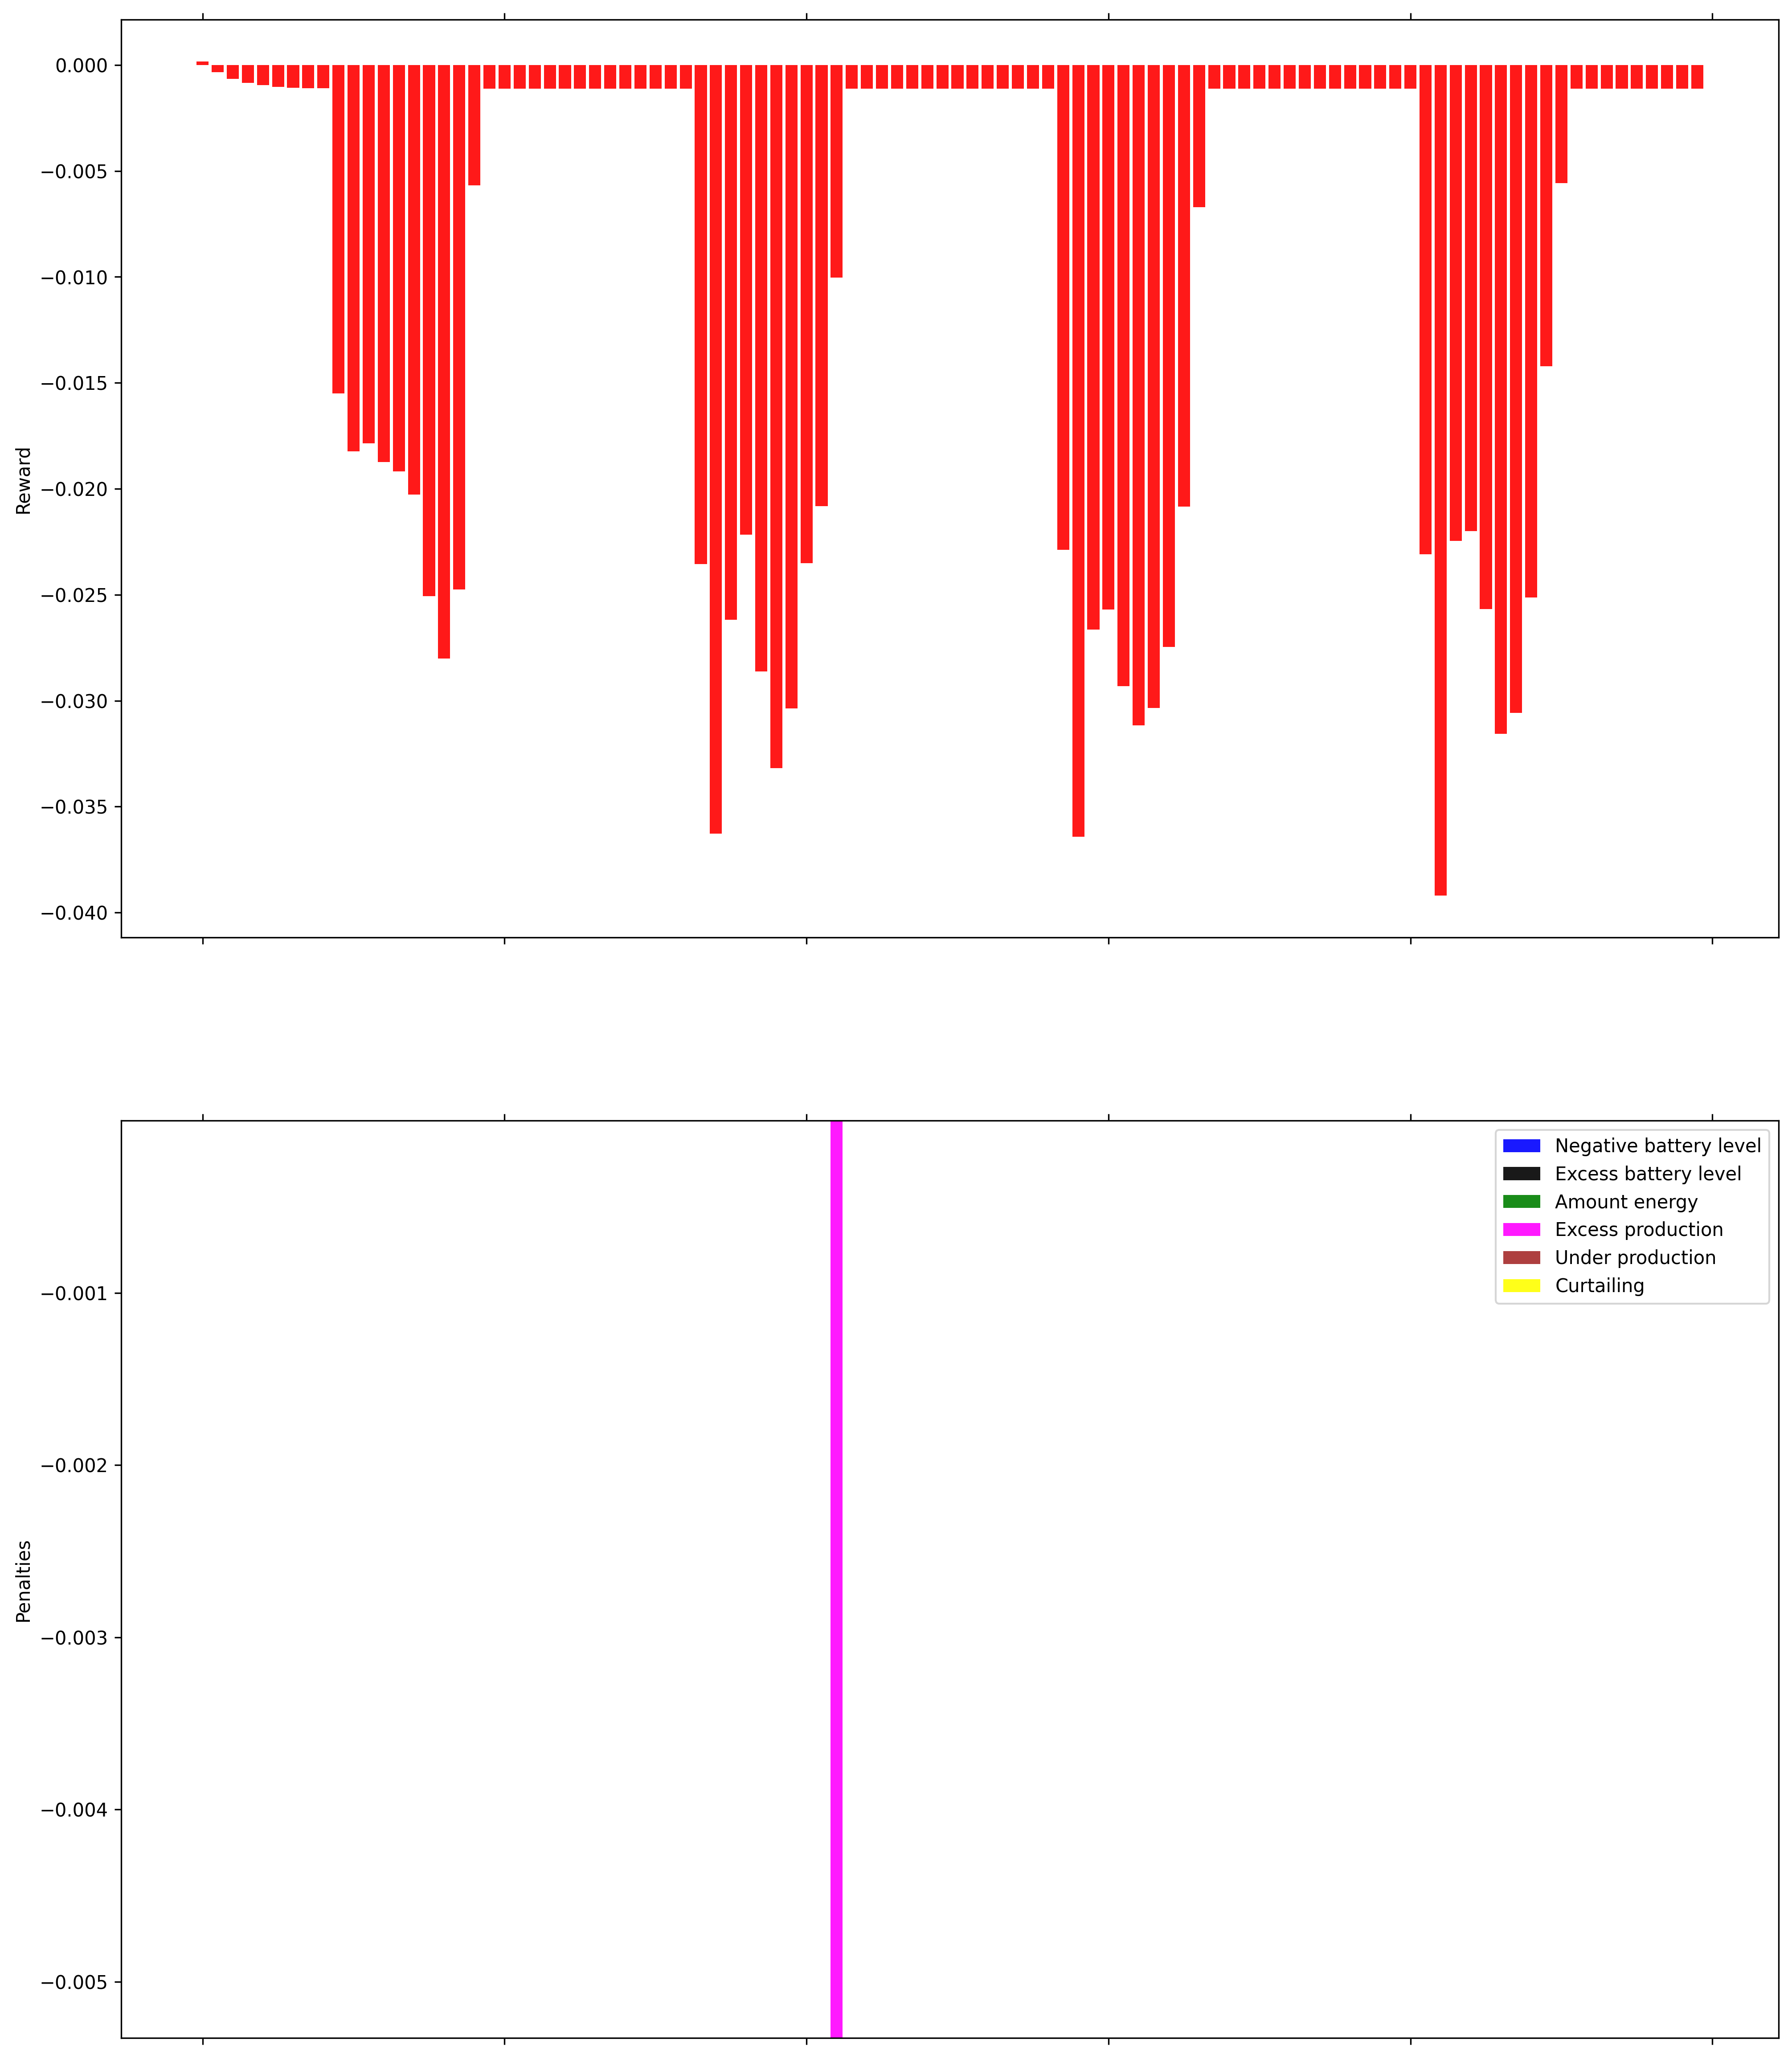

In [4]:
rl_model_testing(results_path=results_path,
                 len_t=len_t_test,
                 whole_year_supply_df=whole_year_supply_df,
                 curtail_unit_cost=curtail_unit_cost,
                 h2_demand=houry_demand_train,
                 battery_storage_capacity=battery_storage_capacity,
                 electrolyzer_cost=electrolyzer_cost,
                 h2_price=h2_price,
                 penalty_unit_cost=penalty_unit_cost,
                 save_results=False,
                 parcial_results=True,
                 model=model,
                 baseline_path=baseline_path)

### 

In [ ]:
rl_model_testing(results_path=results_path,
                 len_t=len_t_test,
                 whole_year_supply_df=whole_year_supply_df_test,
                 curtail_unit_cost=curtail_unit_cost,
                 h2_demand=h2_demand,
                 battery_storage_capacity=battery_storage_capacity,
                 electrolyzer_cost=electrolyzer_cost,
                 h2_price=h2_price,
                 penalty_unit_cost=penalty_unit_cost,
                 save_results=False,
                 parcial_results=False,
                 model=model,
                 baseline_path=baseline_path)

In [5]:
whole_year_supply= load_solar_profile(data_path=data_path, year="TMY P90", initial_month=initial_month_test, number_of_months=num_of_months_test)

Whole Year Supply DF description
             hour        volume
count  744.000000    744.000000
mean   372.500000   2342.088198
std    214.918589   3237.723397
min      1.000000      0.000000
25%    186.750000      0.000000
50%    372.500000      0.000000
75%    558.250000   5513.913680
max    744.000000  10303.159520
The sum of the whole energy volume is 37752422.82975999


Total duration 744
Number of hours without sun: 15
Total Demand: 64400
Buffer Demand: 5000
Hourly Buffer Demand: 429.3333333333333
Remain Demand: 57960.0
Total demand per day integrating the profile: 7768600.0
modeled_demand max 10441.6669921875
modeled_demand max 13330.0


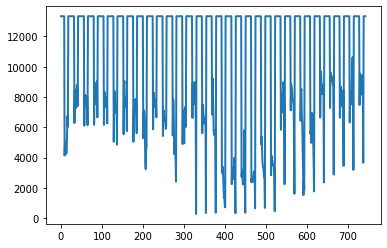

In [8]:
hours_without_sun = (len(whole_year_supply[0:24]) - np.count_nonzero(whole_year_supply[0:24]))
total_demand=64400
buffer_demand=5000

adjusted_total_demand = total_demand
adjusted_buffer_demand = adjusted_total_demand*0.10*31
print(f"Total duration {len(whole_year_supply)}")
print(f"Number of hours without sun: {hours_without_sun}")
print(f"Total Demand: {total_demand}")
print(f"Buffer Demand: {buffer_demand}")

modeled_demand = np.empty(len(whole_year_supply))
# sun_profile=False
# if sun_profile:
hourly_buffer_demand=adjusted_buffer_demand/hours_without_sun
print(f"Hourly Buffer Demand: {hourly_buffer_demand}")

remain_demand = adjusted_total_demand*0.9
print(f"Remain Demand: {remain_demand}")

normalize_solar_in = whole_year_supply/whole_year_supply.sum()
modeled_demand = normalize_solar_in*remain_demand*31
modeled_demand[modeled_demand == 0] = 430
plt.plot(modeled_demand)

print(f'Total demand per day integrating the profile: {modeled_demand.sum()}')
print(f'modeled_demand max {modeled_demand.mean()}')
print(f'modeled_demand max {modeled_demand.max()}')
# else:
#     modeled_demand[whole_year_supply==0] = adjusted_buffer_demand/14
#     modeled_demand[whole_year_supply!=0] = adjusted_total_demand*0.93/10

#     print(f'demand for no Sun {adjusted_buffer_demand/16}')
#     print(f'demand with Sun {adjusted_total_demand*0.93/8}')
#     print(f'Total demand per day integrating the profile: {modeled_demand.sum()}')


In [ ]:
print(f'demand for no Sun {adjusted_buffer_demand/15}')
print(f'demand with Sun {adjusted_total_demand*0.93/9}')



In [ ]:
remain_demand

In [ ]:
print(f'modeled_demand max {modeled_demand.mean()}')
plt.plot(modeled_demand)

In [ ]:
plt.plot(normalize_solar_in*remain_demand)

In [ ]:
normalize_solar_in = whole_year_supply/(whole_year_supply.sum())

In [ ]:
plt.plot(normalize_solar_in)

In [ ]:
simpson(normalize_solar_in)

In [ ]:
whole_year_supply.sum()

In [ ]:
whole_year_supply

In [ ]:
(normalize_solar_in*remain_demand)[0:23].sum()